In [41]:
import pickle
import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sys
sys.path.append('/Users/akuan/repos/ppc_project_analysis/tracing_analysis')
import ppc_analysis_functions.figure_plotting as figs

workingDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/analysis_dataframes/'
figsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/figures_working/rev1/'
sessionsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/fromDan/sessions/'

In [42]:
# 220513 single-trial activity for to look at effect of inhibition?
mySessions = ['DW132_20211021','DW132_20211023']
numSessions = len(mySessions)
#mySessions = ['DW132_20211023']
# Load keys to index matches across sessions
keys_path = sessionsDir+"optimalMatchIndices.mat"
with h5py.File(keys_path, 'r') as f: # Load relevant trial data from .mat files
        print(f.keys())
        idx_map = np.array(f['optimal_cell_to_index_map'])
print(idx_map.shape)

trialData = {} # initialize dict for output metrics
sessionData = {}
numCells = idx_map.shape[1]
mat_path = sessionsDir+"%s.mat" % mySessions[0]
with h5py.File(mat_path, 'r') as f: # Load relevant trial data from .mat files
    CaData = np.array(f['binnedSpkData'])
    numBins = CaData.shape[1]
skel_ids = np.arange(numCells)
for skel_id in skel_ids:
    trialData[skel_id] = {}
    trialData[skel_id]['nAct_norm_t'] = np.empty((numBins,0))
    trialData[skel_id]['nAct'] = np.array([])
    trialData[skel_id]['cueType'] = np.array([])
    trialData[skel_id]['isCorrect'] = np.array([])
    trialData[skel_id]['pref_dir_sess'] = np.array([])
    trialData[skel_id]['numSessFound'] = 0
    trialData[skel_id]['type_sess'] = np.array([])

# Load sessions data and assemble concatenated trial data
for s_idx,session in enumerate(mySessions): 
    print(session)
    mat_path = sessionsDir+"%s.mat" % session
    print(mat_path)
    sessionData[session] = {}
    with h5py.File(mat_path, 'r') as f: # Load relevant trial data from .mat files
        print(f.keys())
        test = f
        CaData = np.array(f['binnedSpkData'])
        cueType =  np.array([i[0] for i in np.array(f['trialType'])])
        isCorrect = np.array([i[0] for i in np.array(f['isCorrect'])])
        isInh = np.array(f['isRed'][0])
        isExc = np.array(f['notRed'][0])
        numCells = CaData.shape[0]
        numBins = CaData.shape[1]
        numTrials = CaData.shape[2]

        for skel_id in skel_ids:
            sessionData[session][skel_id] = {}
            roi = int(idx_map[s_idx,skel_id] - 1) # correct for MATLAB indexing!!
            if roi !=-1: # index (matlab) 0 is not found          
                nAct = CaData[roi,:,:] # 
                nAct_mean = np.nanmean(nAct, axis=0) # Avg over timepoints
                nAct_scale = np.nanmean(nAct_mean, axis=0) # Avg over trials for normalization
                nAct_norm = nAct_mean/nAct_scale # Rel act compared to avg act for the session 
                nAct_norm_t = nAct/nAct_scale # For plotting, avg over trials but not timepoints

                l_trials = cueType == 1
                r_trials = cueType == 2
                if np.mean(nAct_mean[l_trials]) > np.mean(nAct_mean[r_trials]):
                    pref_dir = [1]
                else:
                    pref_dir = [2]
                
                sessionData[session][skel_id]['nAct_norm_t'] = nAct_norm_t

                trialData[skel_id]['numSessFound'] = trialData[skel_id]['numSessFound']+1 # increment sess found counter
                trialData[skel_id]['nAct_norm_t'] =  np.concatenate((trialData[skel_id]['nAct_norm_t'], nAct_norm_t), axis=1)
                trialData[skel_id]['nAct'] =  np.concatenate((trialData[skel_id]['nAct'], nAct_norm)) # nAct_norm is default
                trialData[skel_id]['cueType'] = np.concatenate((trialData[skel_id]['cueType'], cueType))
                trialData[skel_id]['isCorrect'] =  np.concatenate((trialData[skel_id]['isCorrect'], isCorrect))
                trialData[skel_id]['pref_dir_sess'] = np.concatenate((trialData[skel_id]['pref_dir_sess'], pref_dir))

                if isInh[roi]:
                    trialData[skel_id]['type_sess'] = np.concatenate((trialData[skel_id]['type_sess'], ['non pyramidal']))
                elif isExc[roi]:
                    trialData[skel_id]['type_sess'] = np.concatenate((trialData[skel_id]['type_sess'], ['pyramidal']))
                else:
                    trialData[skel_id]['type_sess'] = np.concatenate((trialData[skel_id]['type_sess'], ['unknown']))

<KeysViewHDF5 ['optimal_cell_to_index_map']>
(2, 471)
DW132_20211021
/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/fromDan/sessions/DW132_20211021.mat
<KeysViewHDF5 ['binnedSpkData', 'isCorrect', 'isRed', 'notRed', 'trialType']>
DW132_20211023
/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/fromDan/sessions/DW132_20211023.mat
<KeysViewHDF5 ['binnedSpkData', 'isCorrect', 'isRed', 'notRed', 'trialType']>


In [43]:
# Calculate session consensus 

# Number of cells found in both sessions
both = np.array([trialData[i]['numSessFound'] for i in skel_ids]) == 2 
print('%i of %i cells in both sessions ' % (sum(both), len(both)))

# Cell types found in both sessions
sessTypes = np.array([trialData[i]['type_sess'] for i in skel_ids[both]])
sessTypesAgree = np.array([sessTypes[i][0] == sessTypes[i][1] for i in np.arange(len(sessTypes))])
print('%i of %i have matching types ' % (sum(sessTypesAgree), len(sessTypesAgree)))

# Calc cell prefs (but use all cells, calc pref from concat trials)
cell_prefs = np.array([trialData[i]['pref_dir_sess'] for i in skel_ids[both]])
match_pref = [cell_prefs[i][0] == cell_prefs[i][1] for i in np.arange(len(cell_prefs))] 
print('%i of %i have matching pref ' % (sum(match_pref), len(match_pref)))

# Calc cell consensus fields
for skel_id in skel_ids:
    # Pref dir
    l_trials = trialData[skel_id]['cueType'] == 1 
    r_trials = trialData[skel_id]['cueType'] == 2
    if np.mean(trialData[skel_id]['nAct'][l_trials]) > np.mean(trialData[skel_id]['nAct'][r_trials]):
         trialData[skel_id]['pref_dir'] = 1
    else:
         trialData[skel_id]['pref_dir'] = 2
    # Cell type if there are mismatches
    if trialData[skel_id]['numSessFound'] > 1 and trialData[skel_id]['type_sess'][0] != trialData[skel_id]['type_sess'][1]:
        if 'non pyramidal' in trialData[skel_id]['type_sess']: # priority goes to inhibitory label
             trialData[skel_id]['type'] = 'non pyramidal' 
        elif 'pyramidal' in trialData[skel_id]['type_sess']:
             trialData[skel_id]['type'] = 'pyramidal'
        else:
            trialData[skel_id]['type'] = 'unknown'   
    #elif not trialData[skel_id]['type_sess']:
    #    trialData[skel_id]['type'] = 'unknown'
    else:
        trialData[skel_id]['type'] = trialData[skel_id]['type_sess'][0]

match0 = [trialData[i]['pref_dir'] == trialData[i]['pref_dir_sess'][0] for i in skel_ids[both]]
print('%i of %i have matching pref btw one sess0 and consensus ' % (sum(match0), len(match0)))
match1 = [trialData[i]['pref_dir'] == trialData[i]['pref_dir_sess'][1] for i in skel_ids[both]]
print('%i of %i have matching pref btw one sess1 and consensus ' % (sum(match1), len(match1)))

corrects = trialData[1]['isCorrect']
print('%i error trials out of %i' % (np.sum(corrects == 0), len(corrects)))

211 of 471 cells in both sessions 
183 of 211 have matching types 
162 of 211 have matching pref 
192 of 211 have matching pref btw one sess0 and consensus 
181 of 211 have matching pref btw one sess1 and consensus 
14 error trials out of 395


In [35]:
np.sum(np.array([trialData[skel_id]['type'] for skel_id in skel_ids])=='unknown')

64

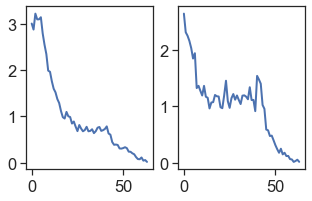

In [37]:
# Check activity for different sessions to make sure indexing is correct
skel_id = 10
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5, style='ticks')
t = np.arange(numBins)

#np.linspace(0,64,num=63)/5.3
#t_cue = np.array([0,25])/5.3
#t_delay = np.array([26,50])/5.3
#t_turn = np.array([51,62])/5.3

# I cell is left selective
plt.subplot(1,2,1)
plt.plot(t,np.nanmean(sessionData[mySessions[0]][skel_id]['nAct_norm_t'],axis=1),'b-', linewidth=2, alpha=1)

plt.subplot(1,2,2)
plt.plot(t,np.nanmean(sessionData[mySessions[1]][skel_id]['nAct_norm_t'],axis=1),'b-', linewidth=2, alpha=1)


In [44]:
# Calculate activity for different types of trials
n_shuf = 500
numCells = idx_map.shape[1]
skel_ids = np.arange(numCells)
for skel_id in skel_ids: 
    nAct_norm_t = trialData[skel_id]['nAct_norm_t']
    nAct = trialData[skel_id]['nAct']
    pref = trialData[skel_id]['pref_dir']
    cueType = trialData[skel_id]['cueType']
    cueDir = cueType#cueDir = trialData[skel_id]['cueDir']
    isCorrect = trialData[skel_id]['isCorrect']
    isError = np.logical_not(isCorrect)

    orig =  np.logical_or(cueType == 1, cueType == 2) # orig 2 cues
    og_correct =  np.logical_and(orig, isCorrect) # orig 2 cues
    og_error =  np.logical_and(orig, isError)
    og_pref =  np.logical_and(orig, cueDir == pref) 
    og_pref_correct =  np.logical_and(og_pref, isCorrect) 
    og_pref_error =  np.logical_and(og_pref, isError) 
    og_nonpref =  np.logical_and(orig, np.logical_not(cueDir == pref))
    og_nonpref_correct =  np.logical_and(og_nonpref, isCorrect) 
    og_nonpref_error =  np.logical_and(og_nonpref, isError) 

    # Save average time-courses for plotting 
    trialData[skel_id]['pref_correct_act'] = np.nanmean(nAct_norm_t[:,og_pref_correct], axis=1) #/ np.nanmean(nAct[og_pref])
    trialData[skel_id]['pref_error_act'] = np.nanmean(nAct_norm_t[:,og_pref_error], axis=1) #/ np.nanmean(nAct[og_pref])
    trialData[skel_id]['nonpref_correct_act'] = np.nanmean(nAct_norm_t[:,og_nonpref_correct], axis=1) #/ np.nanmean(nAct[og_nonpref])
    trialData[skel_id]['nonpref_error_act'] = np.nanmean(nAct_norm_t[:,og_nonpref_error], axis=1) #/ np.nanmean(nAct[og_nonpref])

    # Count number of each type of trial (for reference)
    trialData[skel_id]['n_trials_pref_correct'] = sum(og_pref_correct)
    trialData[skel_id]['n_trials_pref_error'] = sum(og_pref_error)
    trialData[skel_id]['n_trials_nonpref_correct'] = sum(og_nonpref_correct)
    trialData[skel_id]['n_trials_nonpref_error'] = sum(og_nonpref_error)

    if sum(og_pref_error) > 0 and sum(og_nonpref_error) > 0: # only include neurons with >0 error trials
        err_diff_pref = (np.nanmean(nAct[og_pref_error])-np.nanmean(nAct[og_pref_correct]))/np.nanmean(nAct[og_pref])
        err_diff_nonpref = (np.nanmean(nAct[og_nonpref_error])-np.nanmean(nAct[og_nonpref_correct]))/np.nanmean(nAct[og_nonpref])
        pref_diff_err = (np.nanmean(nAct[og_nonpref_error])-np.nanmean(nAct[og_pref_error]))/np.nanmean(nAct[og_error])
        pref_diff_corr = (np.nanmean(nAct[og_pref_correct])-np.nanmean(nAct[og_nonpref_correct]))/np.nanmean(nAct[og_correct])

        err_diff_combined = err_diff_nonpref - err_diff_pref
        
        # Permutation test:
        err_diff_pref_shuf = np.empty((n_shuf))
        err_diff_nonpref_shuf = np.empty((n_shuf))
        err_diff_combined_shuf = np.empty((n_shuf))
        for ix in range(n_shuf):
            nAct_shuf = np.random.permutation(nAct) # Shuffle activity across trials
            err_diff_pref_shuf[ix] = (np.nanmean(nAct_shuf[og_pref_error])-np.nanmean(nAct_shuf[og_pref_correct]))/np.nanmean(nAct_shuf[og_pref])
            err_diff_nonpref_shuf[ix] = (np.nanmean(nAct_shuf[og_nonpref_error])-np.nanmean(nAct_shuf[og_nonpref_correct]))/np.nanmean(nAct_shuf[og_nonpref])
            err_diff_combined_shuf[ix] = err_diff_nonpref_shuf[ix] - err_diff_pref_shuf[ix]
            
        trialData[skel_id]['err_diff_pref'] = err_diff_pref
        trialData[skel_id]['err_diff_nonpref'] = err_diff_nonpref
        trialData[skel_id]['err_diff_pref_shuf'] = err_diff_pref_shuf
        trialData[skel_id]['err_diff_nonpref_shuf'] = err_diff_nonpref_shuf
        trialData[skel_id]['err_diff_pref_prc'] = stats.percentileofscore(err_diff_pref_shuf, err_diff_pref)
        trialData[skel_id]['err_diff_nonpref_prc'] = stats.percentileofscore(err_diff_nonpref_shuf, err_diff_nonpref)

        trialData[skel_id]['pref_diff_err'] = pref_diff_err
        trialData[skel_id]['pref_diff_corr'] = pref_diff_corr

        trialData[skel_id]['err_diff_combined'] = err_diff_combined
        trialData[skel_id]['err_diff_combined_shuf'] = err_diff_combined_shuf
        trialData[skel_id]['err_diff_combined_prc'] = stats.percentileofscore(err_diff_combined_shuf, err_diff_combined)
    else:
        trialData[skel_id].update({'err_diff_pref':np.nan,'err_diff_nonpref':np.nan,
        'err_diff_pref_prc':np.nan, 'err_diff_nonpref_prc':np.nan, 'pref_diff_err':np.nan,
        'pref_diff_corr':np.nan, 'err_diff_combined':np.nan, 'err_diff_combined_shuf':np.nan,
        'err_diff_combined_prc':np.nan})

MN_DF_all = pd.DataFrame()
MN_DF_all['neuron'] = skel_ids
MN_DF_all['type'] = [trialData[i]['type'] for i in skel_ids] 
MN_DF_all['numSessFound'] = [trialData[i]['numSessFound'] for i in skel_ids] 

MN_DF_all['n_trials_pref_correct'] = [trialData[i]['n_trials_pref_correct'] for i in skel_ids] 
MN_DF_all['n_trials_pref_error'] = [trialData[i]['n_trials_pref_error'] for i in skel_ids] 
MN_DF_all['n_trials_nonpref_correct'] = [trialData[i]['n_trials_nonpref_correct'] for i in skel_ids] 
MN_DF_all['n_trials_nonpref_error'] = [trialData[i]['n_trials_nonpref_error'] for i in skel_ids] 

MN_DF_all['pref_correct_act'] = [trialData[i]['pref_correct_act'] for i in skel_ids] 
MN_DF_all['pref_error_act'] = [trialData[i]['pref_error_act'] for i in skel_ids] 
MN_DF_all['nonpref_correct_act'] = [trialData[i]['nonpref_correct_act'] for i in skel_ids] 
MN_DF_all['nonpref_error_act'] = [trialData[i]['nonpref_error_act'] for i in skel_ids] 

MN_DF_all['err_diff_pref'] = [trialData[i]['err_diff_pref'] for i in skel_ids]
MN_DF_all['err_diff_nonpref'] = [trialData[i]['err_diff_nonpref'] for i in skel_ids]
MN_DF_all['err_diff_pref_prc'] = [trialData[i]['err_diff_pref_prc'] for i in skel_ids]
MN_DF_all['err_diff_nonpref_prc'] = [trialData[i]['err_diff_nonpref_prc'] for i in skel_ids]

MN_DF_all['pref_diff_err'] = [trialData[i]['pref_diff_err'] for i in skel_ids]
MN_DF_all['pref_diff_corr'] = [trialData[i]['pref_diff_corr'] for i in skel_ids]

MN_DF_all['err_diff_combined'] = [trialData[i]['err_diff_combined'] for i in skel_ids]
MN_DF_all['err_diff_combined_shuf'] = [trialData[i]['err_diff_combined_shuf'] for i in skel_ids]
MN_DF_all['err_diff_combined_prc'] = [trialData[i]['err_diff_combined_prc'] for i in skel_ids]

<AxesSubplot:xlabel='n_trials_nonpref_error', ylabel='count'>

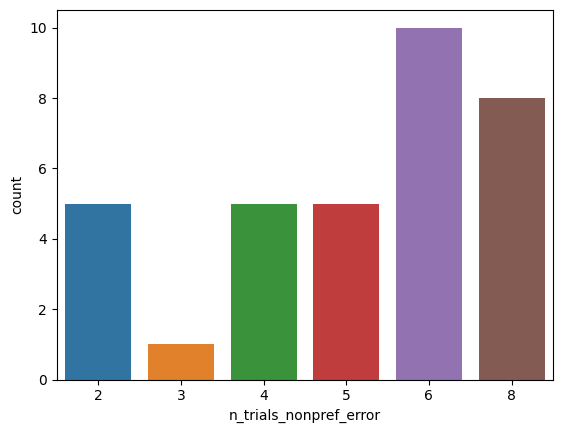

In [7]:
sns.countplot(data = MN_DF_all[MN_DF_all.type == 'non pyramidal'], x = 'n_trials_nonpref_error')

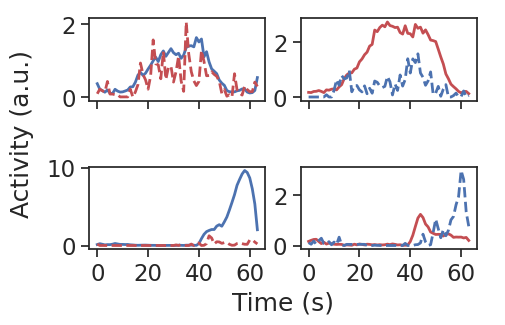

In [8]:
# Plot example neurons activity and MI
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5, style='ticks')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(5, 3),ncols=2, nrows=2, sharey=False, sharex=True)
plt.subplots_adjust(hspace = .8, wspace=0.2)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (s)")
plt.ylabel("Activity (a.u.)")

my_DF = MN_DF_all[MN_DF_all.numSessFound == 2]

my_I_Cell = my_DF[my_DF.neuron == 11]
my_E_Cell = my_DF[my_DF.neuron == 12] #143896 179145

plt.style.use('default')
plt.rcParams['font.size'] = '10'
#fig, ax = plt.subplots(1,1)
#plt.subplots_adjust(wspace=0.05)
t = np.arange(numBins)

#np.linspace(0,64,num=63)/5.3
#t_cue = np.array([0,25])/5.3
#t_delay = np.array([26,50])/5.3
#t_turn = np.array([51,62])/5.3

# I cell is left selective
ax3.plot(t,my_I_Cell['pref_correct_act'].values[0],'b-', linewidth=2, alpha=1)
ax3.plot(t,my_I_Cell['pref_error_act'].values[0],'r--',linewidth=2, alpha=1)
ax4.plot(t,my_I_Cell['nonpref_correct_act'].values[0],'r-', linewidth=2, alpha=1)
ax4.plot(t,my_I_Cell['nonpref_error_act'].values[0],'b--',linewidth=2, alpha=1)
#ax4.set_ylim(ax3.get_ylim())
#ax4.set_yticklabels([])

# E cell is right selective
ax1.plot(t,my_E_Cell['nonpref_correct_act'].values[0],'b-', linewidth=2, alpha=1)
ax1.plot(t,my_E_Cell['nonpref_error_act'].values[0],'r--',linewidth=2, alpha=1)
ax2.plot(t,my_E_Cell['pref_correct_act'].values[0],'r-', linewidth=2, alpha=1)
ax2.plot(t,my_E_Cell['pref_error_act'].values[0],'b--',linewidth=2, alpha=1)
#ax2.set_ylim(ax1.get_ylim())
#ax2.set_yticklabels([])

Excitatory: n = 365, Inh: n = 40
Exc Pref: 0.233983 +- [-0.629848,0.454349]
Inh Pref: 0.495321 +- [-0.663020,0.196347]
WilcoxonResult(statistic=26683.0, pvalue=0.0008725478344261725)
WilcoxonResult(statistic=305.0, pvalue=0.15814550018178708)
MannwhitneyuResult(statistic=7024.0, pvalue=0.6950670740536584)


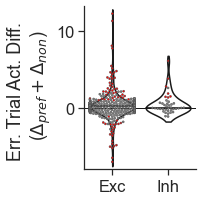

In [49]:
# Plot err diff plots
sns.set(rc={'figure.figsize':(2,3)}, font_scale=1.5, style='ticks')
plt.subplots_adjust(hspace = .4, wspace=0.4)
pal = {'pyramidal':'white','non pyramidal':'white'}

sig_pal = {True:'red',False:'grey'}

MN_DF_all['err_diff_combined_sig'] = np.logical_or(MN_DF_all.err_diff_combined_prc > 97.5,MN_DF_all.err_diff_combined_prc < 2.5)
#MN_DF_all['err_diff_combined_sig'] = MN_DF_all.err_diff_combined_prc > 95

g=figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_combined', order = ['pyramidal','non pyramidal'],palette = pal, cut=1, saturation =0.5) 
#kwargs={"marker":'^'}
sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_combined', order = ['pyramidal','non pyramidal'], hue='err_diff_combined_sig', linewidth=.5,palette=sig_pal,color='k',s=2)
g.axhline(y=0,color='k', linewidth=1)
g.get_legend().remove()
#g.set_ylim([-1,5])
g.set_ylabel('Err. Trial Act. Diff. \n ($Δ_{pref} + Δ_{non}$)')
g.set_xlabel('')
g.set_xticklabels(['Exc','Inh'])

MN_DF_E = MN_DF_all[MN_DF_all.type=='pyramidal'].dropna(subset=['err_diff_combined'])
MN_DF_I = MN_DF_all[MN_DF_all.type=='non pyramidal'].dropna(subset=['err_diff_combined'])
print('Excitatory: n = %i, Inh: n = %i' % (len(MN_DF_E), len(MN_DF_I)))
(E_pref_med,I_pref_med)  = (np.median(MN_DF_E.err_diff_combined),np.median(MN_DF_I.err_diff_combined))
(E_pref_avg,I_pref_avg)  = (np.mean(MN_DF_E.err_diff_combined),np.mean(MN_DF_I.err_diff_combined))

print('Exc Pref: %f +- [%f,%f]' % (E_pref_avg, np.percentile(MN_DF_E.err_diff_combined,25)-E_pref_avg,np.percentile(MN_DF_E.err_diff_combined,75)-E_pref_avg))
print('Inh Pref: %f +- [%f,%f]' % (I_pref_avg, np.percentile(MN_DF_I.err_diff_combined,25)-I_pref_avg,np.percentile(MN_DF_I.err_diff_combined,75)-I_pref_avg))
print(stats.wilcoxon(MN_DF_E.err_diff_combined.values))
print(stats.wilcoxon(MN_DF_I.err_diff_combined.values))
print(stats.mannwhitneyu(MN_DF_E.err_diff_combined.values, MN_DF_I.err_diff_combined.values))

sns.despine()
#plt.savefig(figsDir+'err_diffs_combined.pdf',bbox_inches='tight')


In [51]:
mouse = 'DW132'
session = '20211021_20211023'
out_path = workingDir + mouse+'_'+session+'.pkl'
with open(out_path, 'wb') as f:  
    pickle.dump(MN_DF_all, f)

Excitatory: n = 365, Inh: n = 40
Preferred
Exc Pref: 0.018086 +- [-0.321137,0.524255]
Inh Pref: -0.125531 +- [-0.298832,0.301473]
WilcoxonResult(statistic=27403.0, pvalue=0.002961033961395891)
WilcoxonResult(statistic=356.0, pvalue=0.4679429598081444)
MannwhitneyuResult(statistic=8330.0, pvalue=0.14297623010996463)
Non Preferred
Exc Nonpref: 0.188532 +- [-0.378757,0.540185]
Inh Nonpref: 0.091848 +- [-0.301446,0.694073]
WilcoxonResult(statistic=18879.0, pvalue=2.497596765783117e-13)
WilcoxonResult(statistic=282.0, pvalue=0.08534412626412227)
MannwhitneyuResult(statistic=7676.0, pvalue=0.593154463179256)


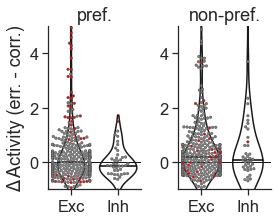

In [52]:
# Plot err diff plots (old metrics with pref/non-pref
sns.set(rc={'figure.figsize':(4,3)}, font_scale=1.5, style='ticks')
plt.subplots_adjust(hspace = .4, wspace=0.4)
pal = {'pyramidal':'white','non pyramidal':'white'}
sig_pal = {True:'red',False:'grey'}
MN_DF_all['err_diff_pref_sig'] = np.logical_or(MN_DF_all.err_diff_pref_prc > 97.5,MN_DF_all.err_diff_pref_prc < 2.5)
MN_DF_all['err_diff_nonpref_sig'] = np.logical_or(MN_DF_all.err_diff_nonpref_prc > 97.5,MN_DF_all.err_diff_nonpref_prc < 2.5)

plt.subplot(1,2,1)
g=figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_pref', order = ['pyramidal','non pyramidal'],palette = pal, cut=1, saturation =0.5)

sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_pref', order = ['pyramidal','non pyramidal'], hue='err_diff_pref_sig', linewidth=.5,palette=sig_pal, color='k',s=2.5)
g.axhline(y=0,color='k', linewidth=1)
g.get_legend().remove()
g.set_ylim([-1,5])
g.set_ylabel('Δ Activity (err. - corr.)')
g.set_xlabel('')
g.set_xticklabels(['Exc','Inh'])
g.set_title('pref.')

plt.subplot(1,2,2)
g=figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_nonpref', order = ['pyramidal','non pyramidal'], palette = pal, cut=1, saturation = 0.5)

sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_nonpref', order = ['pyramidal','non pyramidal'], hue='err_diff_pref_sig', linewidth=.5,palette=sig_pal, color='k',s=2.5)
g.axhline(y=0,color='k', linewidth=1)
g.get_legend().remove()
g.set_ylim([-1,5])
g.set_ylabel('')
g.set_ylabel('')
g.set_xlabel('')
g.set_xticklabels(['Exc','Inh'])
g.set_title('non-pref.')
sns.despine()

MN_DF_E = MN_DF_all[MN_DF_all.type=='pyramidal'].dropna(subset=['err_diff_pref','err_diff_nonpref'])
MN_DF_I = MN_DF_all[MN_DF_all.type=='non pyramidal'].dropna(subset=['err_diff_pref','err_diff_nonpref'])
print('Excitatory: n = %i, Inh: n = %i' % (len(MN_DF_E), len(MN_DF_I)))
print('Preferred')
(E_pref_med,I_pref_med)  = (np.median(MN_DF_E.err_diff_pref),np.median(MN_DF_I.err_diff_pref))
print('Exc Pref: %f +- [%f,%f]' % (E_pref_med, np.percentile(MN_DF_E.err_diff_pref,25)-E_pref_med,np.percentile(MN_DF_E.err_diff_pref,75)-E_pref_med))
print('Inh Pref: %f +- [%f,%f]' % (I_pref_med, np.percentile(MN_DF_I.err_diff_pref,25)-I_pref_med,np.percentile(MN_DF_I.err_diff_pref,75)-I_pref_med))
print(stats.wilcoxon(MN_DF_E.err_diff_pref.values))
print(stats.wilcoxon(MN_DF_I.err_diff_pref.values))

print(stats.mannwhitneyu(MN_DF_E.err_diff_pref.values, 
    MN_DF_I.err_diff_pref.values))
print('Non Preferred')
(E_nonpref_med,I_nonpref_med)  = (np.median(MN_DF_E.err_diff_nonpref),np.median(MN_DF_I.err_diff_nonpref))
print('Exc Nonpref: %f +- [%f,%f]' % (E_nonpref_med, np.percentile(MN_DF_E.err_diff_nonpref,25)-E_nonpref_med,np.percentile(MN_DF_E.err_diff_nonpref,75)-E_nonpref_med))
print('Inh Nonpref: %f +- [%f,%f]' % (I_nonpref_med, np.percentile(MN_DF_I.err_diff_nonpref,25)-I_nonpref_med,np.percentile(MN_DF_I.err_diff_nonpref,75)-I_nonpref_med))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_nonpref.values))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_nonpref.values))
print(stats.mannwhitneyu(MN_DF_E.err_diff_nonpref.values, MN_DF_I.err_diff_nonpref.values))
